# COGS 189 Project - The IT Crowd

__Data__: https://www.kaggle.com/broach/button-tone-sz.

__Objectives__: Our group’s goal is to differentiate Schizophrenic patients from healthy controls using their EEG data when completing an auditory sensory task. There were 3 conditions involved, where participants (1) pressed a button to immediately generate a tone, (2) passively listened to the same tone, or (3) pressed a button without generating a tone.


## Setup

In [86]:
# essentials & plotting
import numpy as np       
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%config InlineBackend.figure_format ='retina'


# EEG signal processing
import scipy.signal as signal
from scipy.signal import butter, sosfiltfilt, sosfreqz  

# ML packages 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split,cross_val_score,StratifiedKFold)
from sklearn.metrics import (accuracy_score, auc, roc_curve, confusion_matrix)

## Define Epoch, ERP Windows

In [3]:
fs = 1024.0 # Hz
epoch_start = -1500  # ms
epoch_end = 1500     # ms

erp_s = 50.0
erp_e = 250.0


# ERP window
s = np.round((erp_s - epoch_start) * (fs / 1000)).astype(int)
e = np.round((erp_e - epoch_start) * (fs / 1000)).astype(int)
# s1 = np.round((erp_s1 - epoch_start) * (fs / 1000)).astype(int)
# e1 = np.round((erp_e1 - epoch_start) * (fs / 1000)).astype(int)

# channel labels
cols = list(pd.read_csv('data/columnLabels.csv'))
channels = cols[4:]

## Import Data

In [4]:
SID = np.array(np.arange(1, 82))
# the subset of subjects to use
# SID_sub = np.append(np.arange(1,16), np.arange(67,82))

label_df = pd.read_csv("data/demographic.csv", usecols=['subject', ' group'])

In [5]:
label_df

,subject,group
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
76,77,1
77,78,1
78,79,1
79,80,1


In [6]:
hc_id = np.array(label_df[label_df[' group']==0]['subject'])
sz_id = np.setdiff1d(SID, hc_id)

hc_id
# # comment when using full-sized data
# hc_id = np.intersect1d(SID_sub, hc_id)
# sz_id = np.setdiff1d(SID_sub, hc_id)

# train_size = 0.4
# n_train_hc = np.round(len(hc_id) * train_size).astype(int)
# n_train_sz = np.round(len(sz_id) * train_size).astype(int) 

# determine the IDs for the training and testing sets
# train_hc_id = np.random.choice(hc_id, replace=False, size=n_train_hc)
# train_sz_id = np.random.choice(sz_id, replace=False, size=n_train_sz)

# test_hc_id = np.setdiff1d(hc_id, train_hc_id)
# test_sz_id = np.setdiff1d(sz_id, train_sz_id)

# train_hc_id, train_sz_id, test_hc_id, test_sz_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 59, 60, 61, 62, 63, 64, 65, 66])

In [1399]:
# Import training and testing data
# data,labels = [],[]

p = 0.67  # train set size
trials = [x for x in range(100)]

train_data = []
train_label = []
test_data = []
test_label = []

for i in SID:
    print('Processing: %d.csv' %i)
    
    df = pd.read_csv('data/{n}.csv/{n}.csv'.format(n=i), names=cols)  
    df['trial'].astype('int64')
    df['condition'].astype('int64')
    
    # randomly assign trials to either train or test set
    trials = [x for x in range(100)]
    train_ind, test_ind = train_test_split(trials, train_size=p,
                                           shuffle=True, random_state=44)
    
    for j in range(1,101):
        # loop through every trial to get data of cond 1 & 3
        c1_df = df[(df['trial'] == j) &
                   (df['condition'] == 1)].iloc[:, 4:]
        
        c3_df = df[(df['trial'] == j) & 
                   (df['condition'] == 3)].iloc[:, 4:]
        
        if (c1_df.shape[0]==0 or c3_df.shape[0]==0):
            next
            
        else:
            # slice the 50 - 250ms ERP interval
            c1_df = c1_df.iloc[s:e, :]
            c3_df = c3_df.iloc[s:e, :]
            
            # subtract condition 3 from condition 1
            trial_data = c1_df.sub(c3_df.values)
            
            # get group label (0 or 1)
            label = label_df.iloc[i-1, 1].astype(int)       

            # data.append(trial_data)
            # labels.append(label)

            if j in train_ind:  # add train data
                # train_data.append(c1_df)
                train_data.append(trial_data)
                train_label.append(label)
                
            elif j in test_ind:  # add test data
                # test_data.append(c1_df) 
                test_data.append(trial_data)
                test_label.append(label)

    
print('Processing complete.')

Processing: 1.csv
Processing: 2.csv
Processing: 3.csv
Processing: 4.csv
Processing: 5.csv
Processing: 6.csv
Processing: 7.csv
Processing: 8.csv
Processing: 9.csv
Processing: 10.csv
Processing: 11.csv
Processing: 12.csv
Processing: 13.csv
Processing: 14.csv
Processing: 15.csv
Processing: 16.csv
Processing: 17.csv
Processing: 18.csv
Processing: 19.csv
Processing: 20.csv
Processing: 21.csv
Processing: 22.csv
Processing: 23.csv
Processing: 24.csv
Processing: 25.csv
Processing: 26.csv
Processing: 27.csv
Processing: 28.csv
Processing: 29.csv
Processing: 30.csv
Processing: 31.csv
Processing: 32.csv
Processing: 33.csv
Processing: 34.csv
Processing: 35.csv
Processing: 36.csv
Processing: 37.csv
Processing: 38.csv
Processing: 39.csv
Processing: 40.csv
Processing: 41.csv
Processing: 42.csv
Processing: 43.csv
Processing: 44.csv
Processing: 45.csv
Processing: 46.csv
Processing: 47.csv
Processing: 48.csv
Processing: 49.csv
Processing: 50.csv
Processing: 51.csv
Processing: 52.csv
Processing: 53.csv
Pr

In [1400]:
np.array(train_data).shape, np.array(test_data).shape

((4952, 205, 70), (2488, 205, 70))

In [1401]:
# define significant channels of interest
chan_3 = ["Fz", "FCz", "Cz"]
chan_5 = ["Fz", "FCz", "Cz", "Pz", "CPz"]
chan_9 = ['Fz', 'FCz', 'Cz', 'FC3', 'FC4', 'C3', 'C4', 'CP3','CP4']

train_3c, train_5c, train_9c = [], [], []
test_3c, test_5c, test_9c = [], [], []

for i in range(len(train_data)):    
    train_3c.append(train_data[i].loc[:, chan_3])
    train_5c.append(train_data[i].loc[:, chan_5])
    train_9c.append(train_data[i].loc[:, chan_9])

for i in range(len(test_data)):
    test_3c.append(test_data[i].loc[:, chan_3])
    test_5c.append(test_data[i].loc[:, chan_5])
    test_9c.append(test_data[i].loc[:, chan_9])

In [1402]:
# Convert all of our data lists into numpy arrays

# full channels
train_data = np.array(train_data)
test_data = np.array(test_data)

train_3c = np.array(train_3c)
train_5c = np.array(train_5c)
train_9c = np.array(train_9c)
train_label = np.array(train_label)

test_3c = np.array(test_3c)
test_5c = np.array(test_5c)
test_9c = np.array(test_9c)
test_label = np.array(test_label)


In [1322]:
# d_3c, d_5c, d_9c = [], [], []

# select data including subsets of channels for classification task
# for i in range(len(data)):    
#     d_3c.append(data[i].loc[:, chan_3])
#     d_5c.append(data[i].loc[:, chan_5])
#     d_9c.append(data[i].loc[:, chan_9])


# data = np.array(data)
# d_3c = np.array(d_3c)
# d_5c = np.array(d_5c)
# d_9c = np.array(d_9c)
# labels = np.array(labels)

# p = 0.3  # train_size

# index = [x for x in range(len(data))]
# train_ind, test_ind = train_test_split(index, train_size=p, shuffle=True, random_state=44)

# # select subset of channels
# train_data = data[train_ind]
# train_3c = d_3c[train_ind]
# train_5c = d_5c[train_ind]
# train_9c = d_9c[train_ind]
# train_label = labels[train_ind]

# test_data = data[test_ind]
# test_3c = d_3c[test_ind]
# test_5c = d_5c[test_ind]
# test_9c = d_9c[test_ind]
# test_label = labels[test_ind]

In [1403]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((4952, 205, 70), (4952,), (2488, 205, 70), (2488,))

In [1404]:
train_3c.shape, train_5c.shape, test_5c.shape, test_9c.shape

((4952, 205, 3), (4952, 205, 5), (2488, 205, 5), (2488, 205, 9))

In [1212]:
# # the very first trial data in test set
# pd.DataFrame(test_data[0])

In [1213]:
# # let's confirm the above data belongs to subject 1-trial 2 (trial 1 excluded)
# df1 = pd.read_csv('data/1.csv/1.csv',names=cols)

# df1_c1 = df1[(df1['trial']==2.0)&(df1['condition']==1.0)&
#              (df1['sample'] >= s) & (df1['sample'] <= e)].iloc[:,3:]
# df1_c3 = df1[(df1['trial']==2.0)&(df1['condition']==3.0)&
#              (df1['sample'] >= s) & (df1['sample'] <= e)].iloc[:,3:]
# df1_c1.sub(df1_c3.values)  # Yes, it is correct

## Plot the Waveforms of All Channels (**SKIP THIS PART

In [54]:
# HC
hc_df = pd.read_csv('data/1.csv/1.csv', names=cols)

# Schizophrenia
sz_df = pd.read_csv('data/81.csv/81.csv', names=cols)

In [55]:
def cond1_sub_cond3(df):
    sub_data= []
    for j in range(1,101):
        c1_df = np.array(df[(df['trial']==j) & (df['condition']==1.0)].iloc[:,4:])
        c3_df = np.array(df[(df['trial']==j) & (df['condition']==3.0)].iloc[:,4:])
        
        if (c1_df.shape[0]==0 or c3_df.shape[0]==0):
            next
        else:
#             c1_df = sosfiltfilt(sos, c1_df)
#             c3_df = sosfiltfilt(sos, c3_df)
            sub_data.append(c1_df - c3_df)
   
    sub_data = np.array(sub_data)
    data = pd.DataFrame(np.mean(sub_data, axis=0))
    data = data.set_axis(channels, axis=1)
    
    return data

hc_erp = cond1_sub_cond3(hc_df)
sz_erp = cond1_sub_cond3(sz_df)

In [59]:
hc_erp

,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,FC3,...,P10,PO8,PO4,O2,VEOa,VEOb,HEOL,HEOR,Nose,TP10
0,-0.193419,-1.032269,0.198019,1.336909,3.075343,1.074769,2.293278,2.701388,2.614718,3.553635,...,-0.213383,0.854333,1.357720,-0.206348,3.003678,4.975163,1.328712,2.805296,4.791602,2.760795
1,-0.295271,-1.322366,0.180834,1.495415,3.240000,1.137314,2.425692,2.446618,2.361225,3.655704,...,0.208401,1.110401,1.622280,0.149876,2.064684,4.301004,1.102526,2.602992,4.564511,2.962787
2,-0.196453,-1.387964,0.303808,1.688163,3.361959,0.904697,2.356121,2.352614,2.229063,3.877149,...,0.324440,1.231247,1.871158,0.206027,1.457583,4.163356,0.706277,2.386566,4.558483,3.379567
3,-0.273579,-1.332461,0.499291,1.543931,3.154511,0.494598,2.109975,2.117226,1.985535,3.854553,...,0.068273,0.808259,1.617774,-0.326500,1.132286,4.400532,0.560206,2.151876,4.870394,3.315286
4,-0.075631,-0.852352,0.789799,1.773294,3.357592,0.637886,2.283432,2.277111,2.178068,3.992391,...,-0.067059,0.852127,1.793693,-0.260029,1.297391,4.255114,0.831214,1.905660,5.097762,3.497366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,-1.215293,-2.153886,0.646333,-0.996272,1.332100,0.085969,0.893098,1.199634,1.169082,1.095147,...,-1.714196,-1.647731,-2.121908,-2.810511,-3.450284,6.077647,1.353500,0.426116,8.874115,-1.944734
3068,-1.625596,-2.202104,0.730244,-0.887992,1.313334,0.146528,0.916944,0.897741,0.904419,1.031142,...,-2.093945,-2.064769,-2.237409,-3.040142,-3.296015,6.190116,0.863143,0.029479,8.383647,-2.072573
3069,-2.128929,-2.322495,1.056815,-0.647237,1.519422,0.370960,0.746280,0.937902,0.957193,1.190233,...,-2.167299,-2.005705,-2.128628,-3.013142,-2.702582,6.318693,0.321131,-0.130974,8.396140,-2.190485
3070,-1.883878,-2.043772,1.425394,-0.301771,2.060924,0.863429,0.943997,1.208968,1.253880,1.716262,...,-1.822985,-1.653352,-1.993824,-2.646171,-2.327894,6.767704,0.664323,0.340806,9.088229,-1.959447


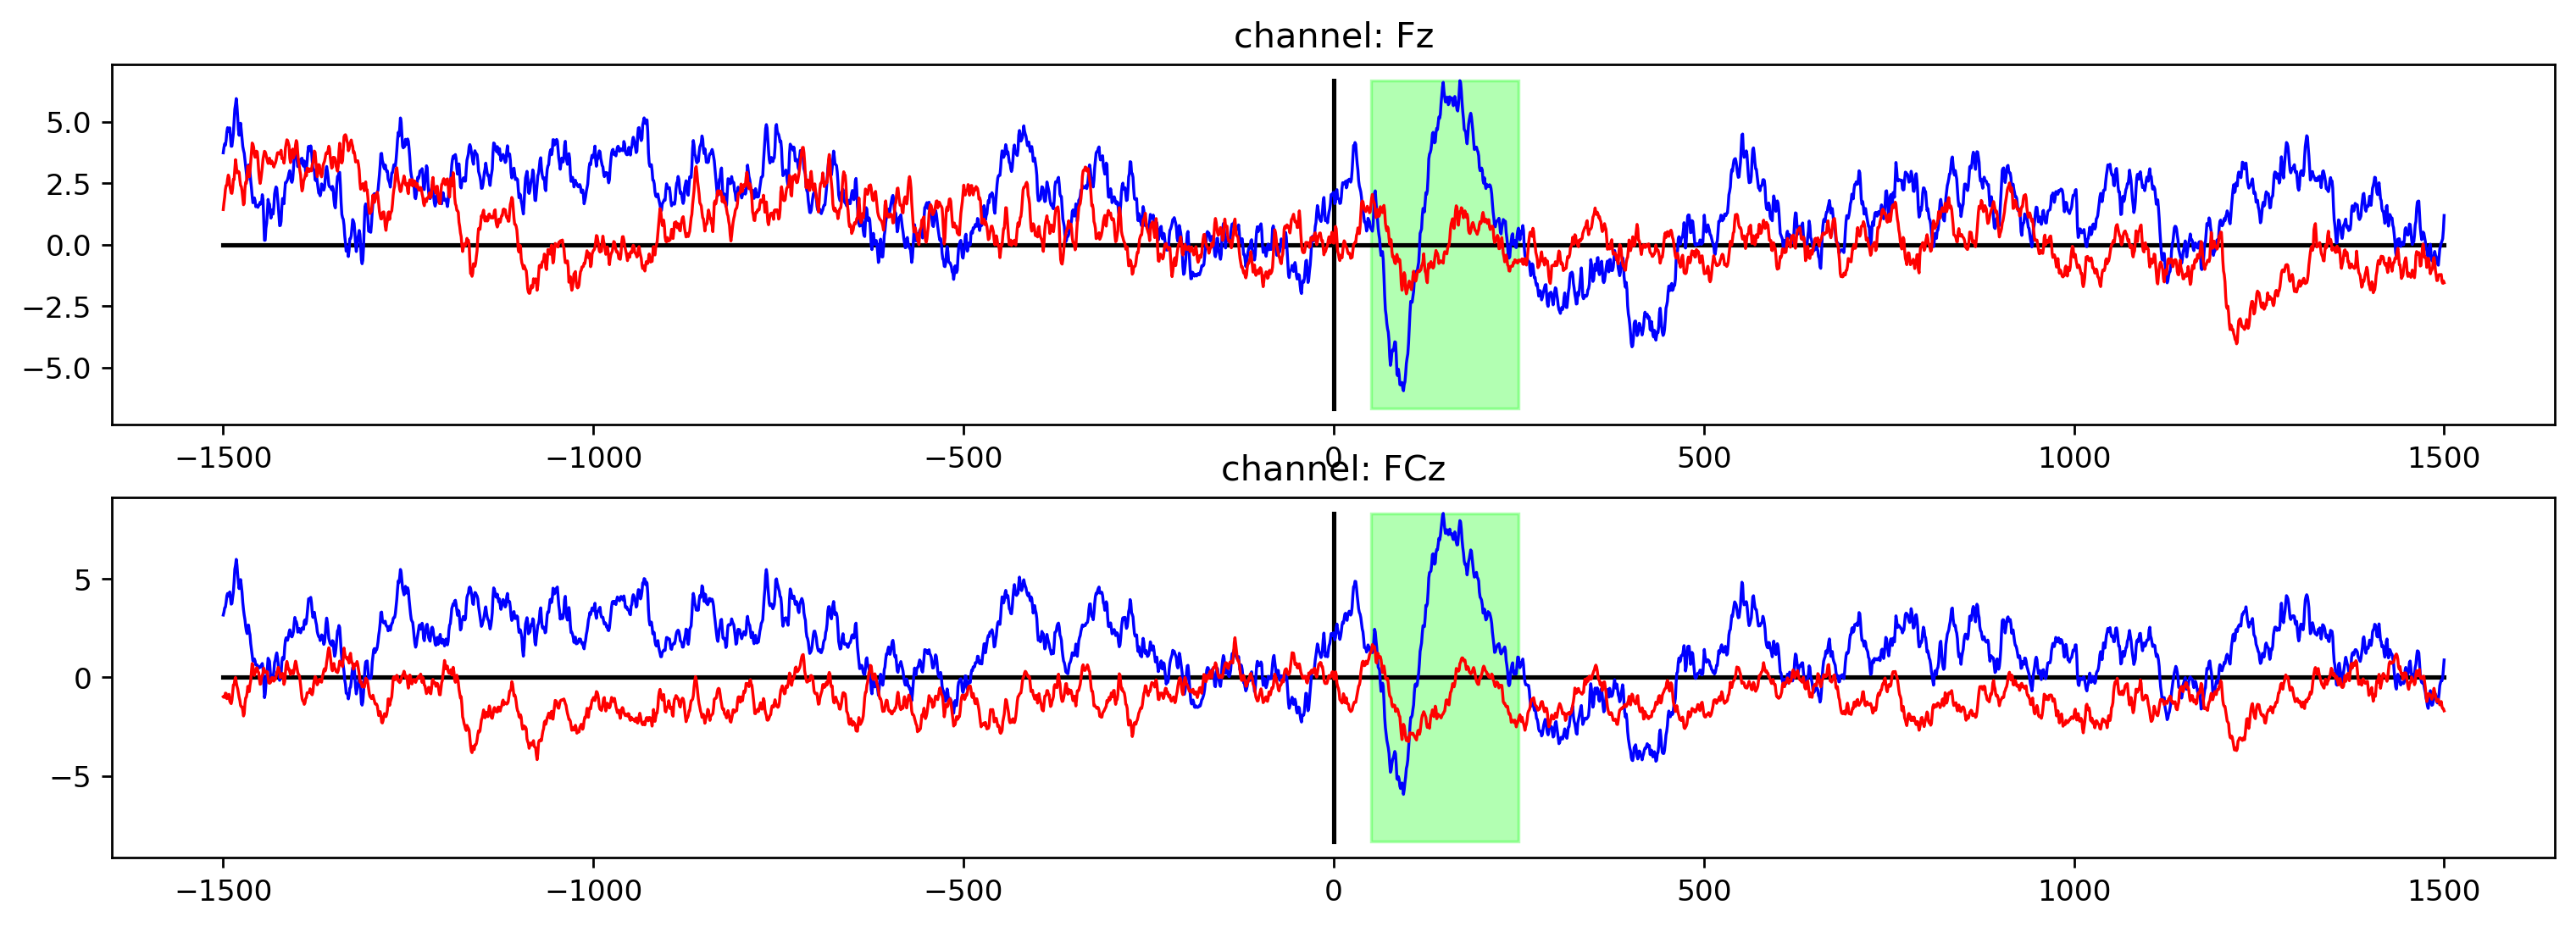

In [93]:
times = np.linspace(epoch_start, epoch_end, len(hc_erp))

# channels of interest
chan = ['Fz', 'FCz']#, 'FPz', 'FCz', 'Cz', 'CPz', 'FC1','FC2','FC3', 'FC4',
#         'C1', 'C2', 'C3', 'C4', 'CP1', 'CP2', 'CP3','CP4']



fig, axes = plt.subplots(len(chan),1,figsize=(15,5))
fig.set_dpi(124)

for i in range(len(chan)):

    hc_erp_c = hc_erp.loc[:, chan[i]]
    sz_erp_c = sz_erp.loc[:, chan[i]]
    
    min_y = -max(max(abs(hc_erp_c)),max(abs(sz_erp_c)))
    max_y = -min_y
    
    erp_win = patches.Rectangle([erp_s, min_y], erp_e-erp_s, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)
    
    axes[i].plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
    axes[i].plot([0, 0], [min_y, max_y], color='k')  
    
    axes[i].plot(times, hc_erp_c, 'b', linewidth=1)
    axes[i].plot(times, sz_erp_c, 'r', linewidth=1)
    axes[i].add_patch(erp_win)

    axes[i].set_title('channel: {}'.format(chan[i]))

# fig, ax = plt.subplots(figsize=(15,5))
# plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
# plt.plot([0, 0], [min_y, max_y], color='k'); 

# plt.plot(times, hc_erp, 'b', linewidth=2)
# plt.plot(times, sz_erp, 'r', linewidth=2)

# plt.legend()

plt.show()

## Feature-extraction: Windowed Means:
- Reduce dimensionality (70$\rightarrow$ 3, 5, 9; 206$\rightarrow$ 5,10) 
- and flattening the shape of data from 3D to 2D 


In [1466]:
n_wm = 8 # num of windows

def wm(X, n_wm=n_wm):
    # num of time points per window
    w_size = np.round((train_data.shape[1]) / n_wm).astype(int)
    # create the new data frame
    X_ = np.zeros((X.shape[0], n_wm, X.shape[-1]))
    
    for i in range(n_wm):
        start = w_size * i
        end = w_size * (i+1)
        X_[:,i,:] = np.mean(X[:, start:end, :], 1)
    
    return X_
    

In [1467]:
X_train = wm(train_data)
X_train_3c = wm(train_3c)
X_train_5c = wm(train_5c)
X_train_9c = wm(train_9c)
y_train = train_label

X_train.shape, y_train.shape

((4952, 8, 70), (4952,))

In [1468]:
X_test = wm(test_data)
X_test_3c = wm(test_3c)
X_test_5c = wm(test_5c)
X_test_9c = wm(test_9c)
y_test = test_label

X_test.shape, y_test.shape

((2488, 8, 70), (2488,))

In [1469]:
X_train = X_train.reshape(-1, X_train.shape[0]).T
X_train_3c = X_train_3c.reshape(-1, X_train_3c.shape[0]).T
X_train_5c = X_train_5c.reshape(-1, X_train_5c.shape[0]).T
X_train_9c = X_train_9c.reshape(-1, X_train_9c.shape[0]).T

X_test = X_test.reshape(-1, X_test.shape[0]).T
X_test_3c = X_test_3c.reshape(-1, X_test_3c.shape[0]).T
X_test_5c = X_test_5c.reshape(-1, X_test_5c.shape[0]).T
X_test_9c = X_test_9c.reshape(-1, X_test_9c.shape[0]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

X_train shape is now: (4952, 560)
X_test  shape is now: (2488, 560)


In [1470]:
X_train_df = pd.DataFrame(X_train_9c)
X_train_df['label'] = train_label
X_train_df['group'] = 'train'

X_test_df = pd.DataFrame(X_test_9c)
X_test_df['label'] = test_label
X_test_df['group'] = 'test'
# X_train_df.to_csv("data/X_train_random-split-trial.csv")
# X_test_df.to_csv("data/X_test_random-split-trial.csv")

In [1471]:
df = X_train_df.append(X_test_df)
# df.to_csv('data/cleaned.csv')

## Directly import pre-processed data

In [33]:
df = pd.read_csv("data/cleaned.csv", index_col=0)
X_train_9c = np.array(df[df['group']=='train'].iloc[:,:-2])
y_train = np.array(df['label'][:len(X_train_9c)])

X_test_9c = np.array(df[df['group']=='test'].iloc[:,:-2])
y_test = np.array(df['label'][len(X_train_9c):])

In [34]:
X_train_9c.shape, X_test_9c.shape, y_train.shape, y_test.shape

((4952, 72), (2488, 72), (4952,), (2488,))

## Classification: LDA

In [35]:
def my_LDA_CV(X, y, n_splits=10): # for k-fold cross-validation):
    train_accs, test_accs, aucs, tprs = [],[],[],[]
    mean_fpr = np.linspace(0,1,100)   
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=9999)
    for train, test in kf.split(X, y):
        # obtain classifier
        clf = LDA(solver='svd').fit(X[train], 
                                    y[train])

        # test metrics
        test_pred = clf.predict(X[test])
        test_acc = accuracy_score(y[test], test_pred)
        test_accs.append(test_acc)
        
        # AUC
        fpr, tpr, t = roc_curve(y[test], test_pred)
        tprs.append( np.interp(mean_fpr, fpr, tpr) )
        aucs.append( auc(fpr, tpr) )
    
    # mean test accuracy
    test_acc = np.mean(test_accs)
    
    return test_acc, aucs, tprs



def plot_roc(tprs, text, mean_fpr = np.linspace(0,1,100)):
    # AUC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # plot ROC curve
    plt.plot(mean_fpr, mean_tpr,
             lw=2, alpha=1,
             label=r'%s channels (AUC = %0.2f )'%(text, mean_auc))
    

In [36]:
# X = X_train
# X1 = X_train_3c
# X2 = X_train_5c
X3 = X_train_9c
y = y_train

# 10-fold cross validation
# test_acc0, aucs0, tprs0 = my_LDA_CV(X, y)
# test_acc1, aucs1, tprs1 = my_LDA_CV(X1, y)
# test_acc2, aucs2, tprs2 = my_LDA_CV(X2, y)
test_acc3, aucs3, tprs3 = my_LDA_CV(X3, y)

# print("full channels mean accuracy: %f" % test_acc0)
# print("3 channels  mean accuracy: %f" % test_acc1)
# print("5 channels  mean accuracy: %f" % test_acc2)
print("9 channels  mean accuracy: %f" % test_acc3)

9 channels  mean accuracy: 0.813609


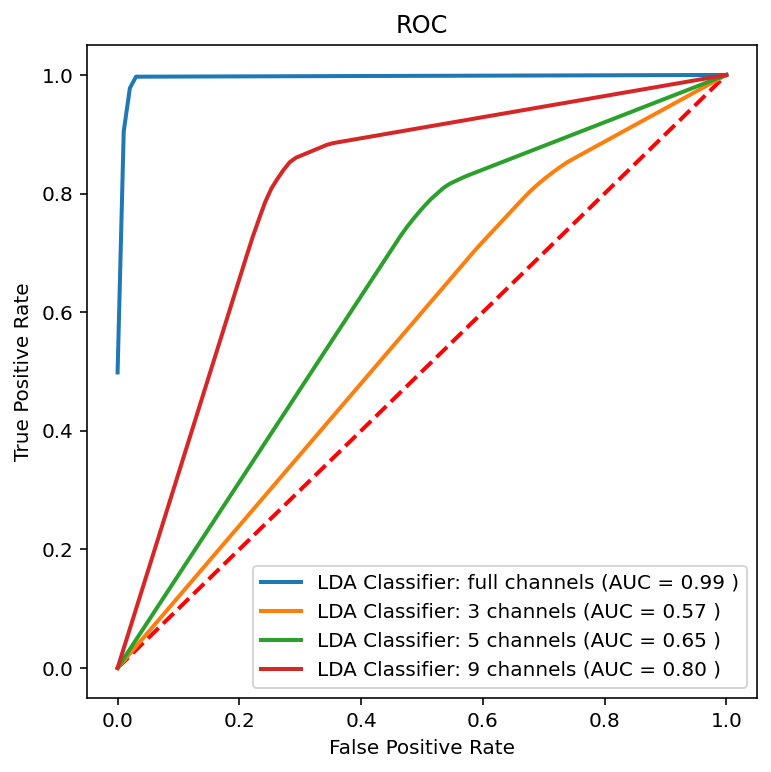

In [1475]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2, color = 'r')

plot_roc(tprs0, text='LDA Classifier: full')
plot_roc(tprs1, text='LDA Classifier: 3')
plot_roc(tprs2, text='LDA Classifier: 5')
plot_roc(tprs3, text='LDA Classifier: 9')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [1573]:
# test
lda = LDA(solver='lsqr', shrinkage=0.03).fit(X_train_9c, y)
# acc = clf.score(X_test_9c, y_test)
lda_pred = lda.predict(X_test_9c)
lda_test_acc = accuracy_score(y_test, pred)

print("Test accuracy: %f" % lda_test_acc)
print(confusion_matrix(y_test, lda_pred))

Test accuracy: 0.552251
[[ 325  679]
 [ 435 1049]]


# Visualizating with UMAP

In [37]:
import umap

In [81]:
def draw_umap(data, hue, RS = 2022):
    embedding = umap.UMAP(random_state=RS).fit_transform(data)
   
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
                    hue=hue, 
                    palette='hls', s=50)

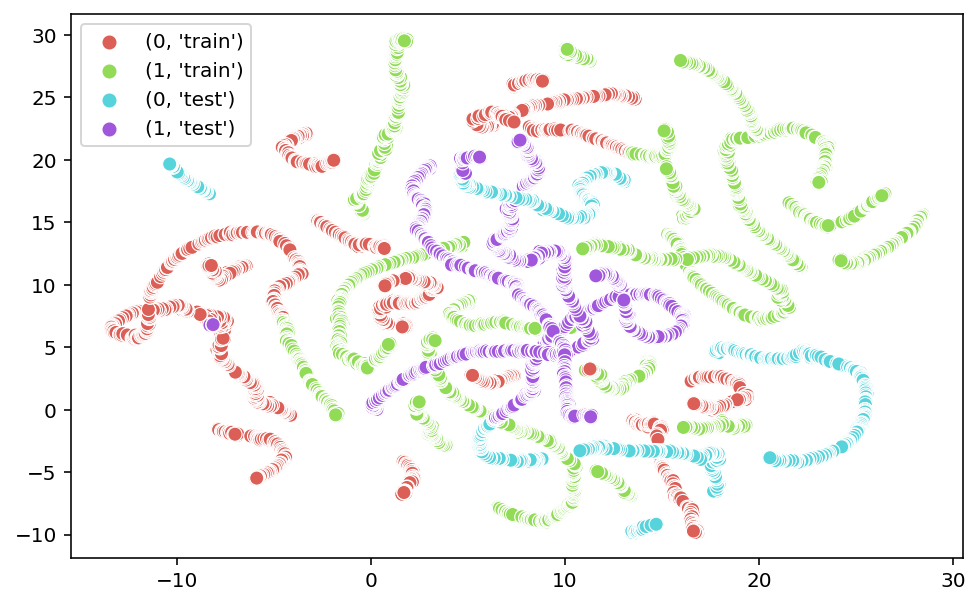

In [64]:
draw_umap(df.iloc[:,:-2], hue=df[['label','group']].apply(tuple, axis=1))

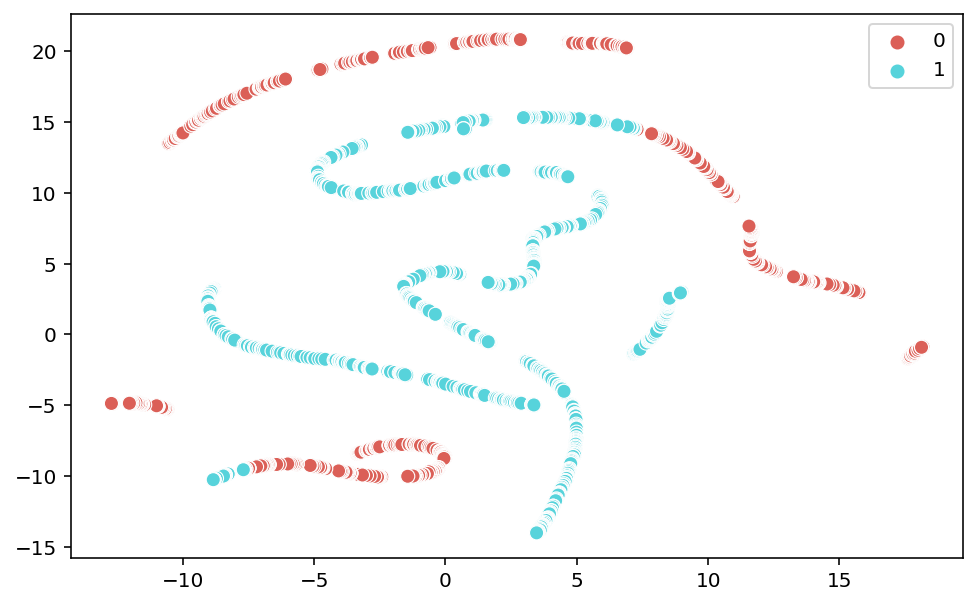

In [82]:
draw_umap(X_test_9c, hue=y_test)

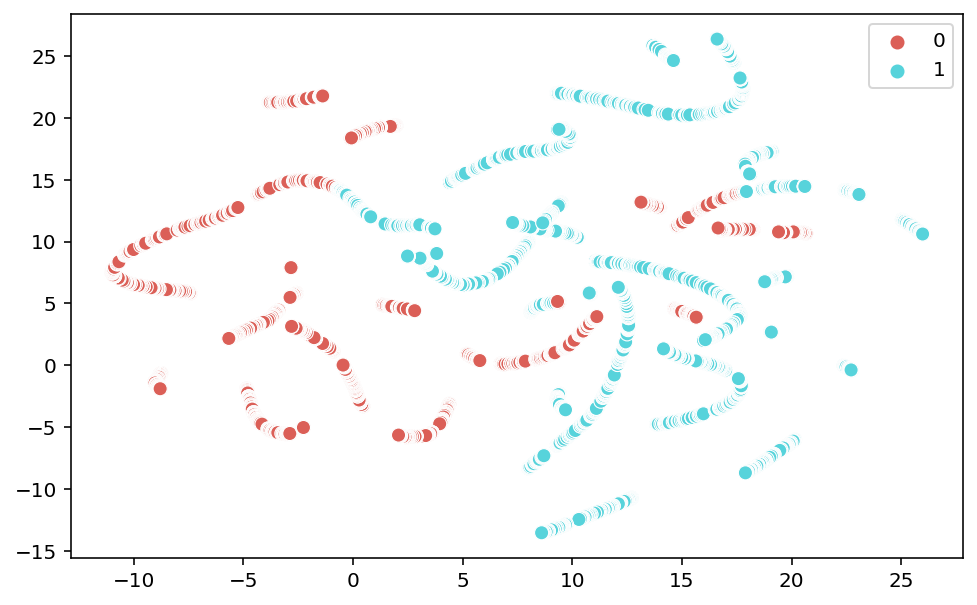

In [83]:
draw_umap(X_train_9c, hue=y_train)

## Logistic Regression

In [1522]:
from sklearn.linear_model import LogisticRegression

In [94]:
def my_Logit_CV(X, y, kernel='rbf', n_splits=10): # for k-fold cross-validation):
    test_accs, aucs, tprs = [],[],[]
    mean_fpr = np.linspace(0,1,100)   
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=9999)
    for train, test in kf.split(X, y):
        # obtain classifier
        clf = LogisticRegression().fit(X[train], y[train])
        
        # test set accuracy
        test_pred = clf.predict(X[test])
        test_acc = accuracy_score(y[test], test_pred)
        test_accs.append(test_acc)
        
        # AUC
        fpr, tpr, t = roc_curve(y[test], test_pred)
        tprs.append( np.interp(mean_fpr, fpr, tpr) )
        aucs.append( auc(fpr, tpr) )
    
    # mean test accuracy
    test_acc = np.mean(test_accs)
    
    return test_acc, aucs, tprs

In [97]:
lgr = LogisticRegression(C=0.01).fit(X_train_9c, y_train)

acc = cross_val_score(lgr, X_train_9c, y_train, cv=10)
print(acc,"\n")
print(np.mean(acc))

[0.61693548 0.71774194 0.60808081 0.63030303 0.55353535 0.52323232
 0.70707071 0.67272727 0.56565657 0.51313131] 

0.6108414793092213


In [103]:
logit_acc, logit_aucs, logit_tprs = my_Logit_CV(X_train_9c, y_train)

np.mean(logit_aucs)

0.8004846319251202

In [98]:
lgr.score(X_test_9c, y_test)

0.545016077170418

## Kernel SVM

In [ ]:
from sklearn.svm import SVC

In [101]:
def my_SVM_CV(X, y, kernel='rbf', n_splits=10): # for k-fold cross-validation):
    test_accs, aucs, tprs = [],[],[]
    mean_fpr = np.linspace(0,1,100)   
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=9999)
    for train, test in kf.split(X, y):
        # obtain classifier
        clf = SVC().fit(X[train], y[train])
        
        # test set accuracy
        # test_proba = clf.predict_proba(X[test])
        test_pred = clf.predict(X[test])
        test_acc = accuracy_score(y[test], test_pred)
        test_accs.append(test_acc)
        
        # AUC
        fpr, tpr, t = roc_curve(y[test], test_pred)
        tprs.append( np.interp(mean_fpr, fpr, tpr) )
        aucs.append( auc(fpr, tpr) )
    
    # mean train and test accuracy
#     train_acc = np.mean(train_accs)
    test_acc = np.mean(test_accs)
    
    return test_acc, aucs, tprs

In [102]:
# svm_acc0, svm_aucs0, svm_tprs0 = my_SVM_CV(X_train, y_train)
svm_acc1, svm_aucs1, svm_tprs1 = my_SVM_CV(X_train_9c, y_train)

print("SVM Classifier  mean accuracy: %f" % svm_acc1)

SVM Classifier  mean accuracy: 0.996163


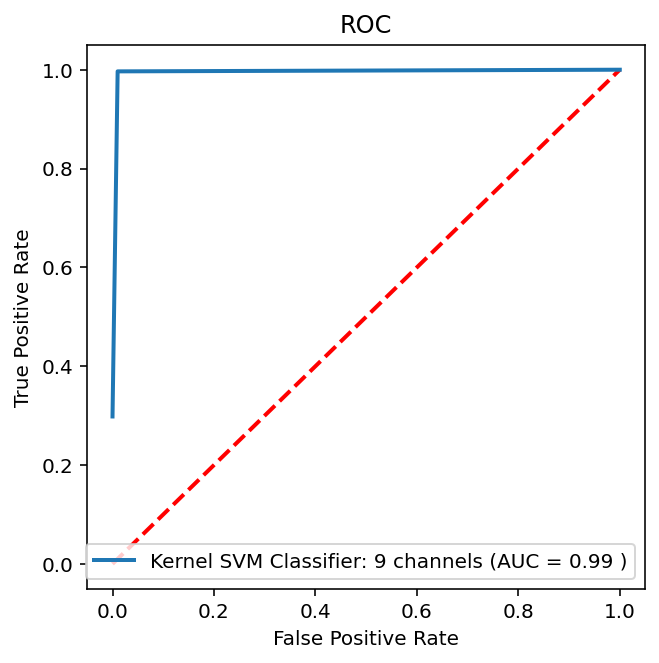

In [1575]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2, color = 'r')

plot_roc(svm_tprs1, text='Kernel SVM Classifier: 9')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [1578]:
svm = SVC(kernel='rbf',random_state=44).fit(X_train_9c, y_train)

svm_pred = svm.predict(X_test_9c)
svm_test_acc = accuracy_score(y_test, svm_pred)
print("Classifier: SVM; Test accuracy: %f" % svm_test_acc)
print(confusion_matrix(y_test, svm_pred))

Classifier: SVM; Test accuracy: 0.668006
[[ 405  599]
 [ 227 1257]]


## Random Forest

In [1552]:
from sklearn.ensemble import RandomForestClassifier

In [1559]:
def my_RF_cv(X, y, n_splits=10):
    test_accs, tprs, aucs = [],[],[]
    mean_fpr = np.linspace(0,1,100)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=40)
    for train, test in kf.split(X,y):
        clf = RandomForestClassifier(random_state=44).fit(X[train],
                                                          y[train])

        # test set classification metrics
        test_pred = clf.predict(X[test])
        acc = accuracy_score(y[test], test_pred)
        test_accs.append(acc)
        
        fpr, tpr, threshold = roc_curve(test_pred, y[test])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append( auc(fpr, tpr) )
        
    test_acc = np.mean(test_accs)
    
    return test_acc, aucs, tprs


Classifier: RF	 mean accuracy: 0.976173


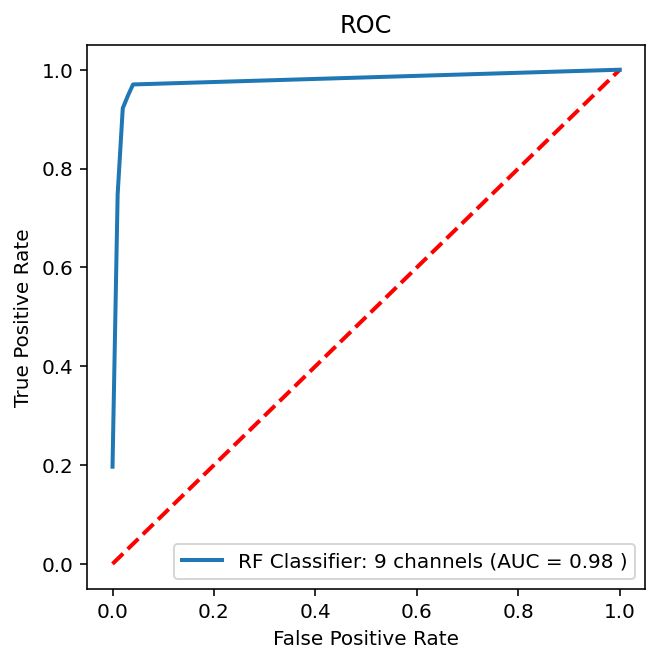

In [1561]:
rf_acc1, rf_aucs1, rf_tprs1 = my_RF_cv(X_train_9c, y_train)

print("Classifier: RF\tmean accuracy: %f" % rf_acc1)


plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2, color = 'r')

plot_roc(rf_tprs1, text='RF Classifier: 9')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [1572]:
rf = RandomForestClassifier(random_state=42).fit(X_train_9c,
                                                 y_train)
rf_pred = rf.predict(X_test_9c)
rf_test_acc = accuracy_score(y_test, rf_pred)

print("RF Classifier\t Test accuracy: %f" % rf_test_acc)
print(confusion_matrix(y_test, rf_pred))

RF Classifier	 Test accuracy: 0.717042
[[ 380  624]
 [  80 1404]]


## LightGBM

In [41]:
# conda install -c conda-forge lightgbm

In [42]:
from lightgbm import LGBMClassifier

In [52]:
lgb_rf = LGBMClassifier( random_state=44)
accs = cross_val_score(lgb_rf, X_train_9c, y_train, cv=10)
print(accs, '\n')
print("LGB cv score: %f" %np.mean(accs))

[0.78427419 0.78024194 0.82424242 0.78181818 0.79393939 0.77373737
 0.8        0.70505051 0.57777778 0.68686869] 

LGB cv score: 0.750795


In [53]:
lgb = lgb_rf.fit(X_train_9c, y_train)
lgb_pred = lgb.predict(X_test_9c)
lgb_test_acc = accuracy_score(y_test, lgb_pred)

print("LGB Classifier\tTest accuracy: %f" %lgb_test_acc)

LGB Classifier	Test accuracy: 0.719051
